In [1]:
! git clone https://github.com/stefyste/RIAWELC.git

Cloning into 'RIAWELC'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 528 (delta 4), reused 103 (delta 0), pack-reused 382
Receiving objects: 100% (528/528), 471.32 MiB | 18.31 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Updating files: 100% (20/20), done.


In [3]:
%cd RIAWELC

[Errno 2] No such file or directory: 'RIAWELC'
/content/RIAWELC


In [4]:
%cd Dataset_partitioned

/content/RIAWELC/Dataset_partitioned


In [5]:
!pip install pyunpack
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.9 MB/s eta 0:00:00


In [6]:
import os
from pyunpack import Archive

rar_file = '/content/RIAWELC/Dataset_partitioned/RIAWELC_dataset.part01.rar'
output_dir = '/content/extracted_data'
os.mkdir(output_dir)
Archive(rar_file).extractall(output_dir)

In [7]:
train_dir = '/content/extracted_data/DB - Copy/training'
validation_dir = '/content/extracted_data/DB - Copy/validation'
test_dir = '/content/extracted_data/DB - Copy/testing'

In [8]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k

In [ ]:
img_width, img_height = 227, 227
#nb_train_samples = 1800
#nb_validation_samples = 600
batch_size = 32
epochs = 100

In [ ]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=40)

validation_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=40)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = validation_datagen.flow_from_directory(
validation_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 15863 images belonging to 4 classes.
Found 6101 images belonging to 4 classes.


**Transfer Learning with VGG19**

In [ ]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in model.layers[:5]:
    layer.trainable = False

In [ ]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

model_final = Model(inputs = model.input, outputs = predictions)

model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [18]:
from keras.callbacks import (
   Callback,
   EarlyStopping,
   ModelCheckpoint,
   TensorBoard
)

In [ ]:
file_name = 'my_saved_model_VGG19'
tensorboard =TensorBoard(log_dir="/content/drive/MyDrive/Stage/Stage Falcon/logs/{}".format(file_name))

# Callbacks
cb = [
    ModelCheckpoint("VGG19.h5", save_best_only=True),
    tensorboard]


Tensorboard
```
# python -m tensorboard.main --logdir=logs
```



In [ ]:
model_final.fit(
train_generator,
steps_per_epoch = batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = batch_size,
callbacks=cb)

Epoch 1/100
32/32 [==============================] - 41s 1s/step - loss: 1.3668 - accuracy: 0.3252 - val_loss: 1.2222 - val_accuracy: 0.4414
Epoch 2/100
32/32 [==============================] - 40s 1s/step - loss: 1.2214 - accuracy: 0.4551 - val_loss: 1.1912 - val_accuracy: 0.4629
Epoch 3/100
32/32 [==============================] - 39s 1s/step - loss: 1.2000 - accuracy: 0.4512 - val_loss: 1.1572 - val_accuracy: 0.4717
Epoch 4/100
32/32 [==============================] - 33s 1s/step - loss: 1.1625 - accuracy: 0.4961 - val_loss: 1.1397 - val_accuracy: 0.5029
Epoch 5/100
32/32 [==============================] - 35s 1s/step - loss: 1.1323 - accuracy: 0.5068 - val_loss: 1.0905 - val_accuracy: 0.5410
Epoch 6/100
32/32 [==============================] - 39s 1s/step - loss: 1.1033 - accuracy: 0.5420 - val_loss: 1.0819 - val_accuracy: 0.5430
Epoch 7/100
32/32 [==============================] - 40s 1s/step - loss: 1.1083 - accuracy: 0.5352 - val_loss: 1.0405 - val_accuracy: 0.5820
Epoch 8/100
3

In [ ]:
model_final.save('/content/drive/MyDrive/Stage/Stage Falcon/VGG19_model.h5')

**Bloc Test**

---



In [ ]:
VGG19='/content/RIAWELC/Dataset_partitioned/VGG19.h5'
import h5py
import numpy as np
file = h5py.File(VGG19, 'r')

# List all the datasets in the file
print("Datasets in the HDF5 file:")
for param in file:
    print(param)

print(file['model_weights'])
group=file['model_weights']
print("Datasets in the group:")
for dataset_name in group:
    print(dataset_name)
dataset =group['top_level_model_weights']
print(dataset)



---



In [ ]:
test_generator = train_datagen.flow_from_directory(
test_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle = False)

Found 2443 images belonging to 4 classes.


In [ ]:
pred = model_final.predict_generator(test_generator,steps = len(test_generator), verbose = 1)

<ipython-input-31-bde2203e6fa8>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model_final.predict_generator(test_generator,steps = len(test_generator), verbose = 1)


77/77 [==============================] - 39s 497ms/step


In [ ]:
true_classes = test_generator.classes
print(true_classes)

[0 0 0 ... 3 3 3]


In [ ]:
class_labels = list(test_generator.class_indices.keys())
print(class_labels)

['Difetto1', 'Difetto2', 'Difetto4', 'NoDifetto']


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
import numpy
predicted_classes = numpy.argmax(pred, axis=1)

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    Difetto1       0.92      0.93      0.92       765
    Difetto2       0.95      0.93      0.94       632
    Difetto4       0.89      0.83      0.86       446
   NoDifetto       0.95      0.99      0.97       600

    accuracy                           0.93      2443
   macro avg       0.93      0.92      0.92      2443
weighted avg       0.93      0.93      0.93      2443



**SqueezNet**

* Preprocessing :

In [ ]:
import cv2 as cv
import numpy as np
import os

1. Normalization

In [ ]:
def MinMaxNormalise(img):
    norm_img = (img - img.min()) / (img.max() - img.min())

    return norm_img

2. Contrast-Limited Adaptive Histogram Equalisation (CLAHE)

In [ ]:
def clahe(img, clip=2.0, tile=(8, 8)):
    '''
    This function applies the Contrast-Limited Adaptive
    Histogram Equalisation filter to a given image.
    '''

    # Convert to uint8.
    #img= (img * 255).astype(np.uint8)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # img = skimage.img_as_ubyte(img)
    img = cv.normalize(
        img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv.NORM_MINMAX,
        dtype=cv.CV_32F,
    )
    img_uint8 = img.astype("uint8")

    clahe_create = cv.createCLAHE(clipLimit=clip, tileGridSize=tile)
    clahe_img = clahe_create.apply(img_uint8)

    return clahe_img

In [ ]:
def WeldPreprocess(
    img,
    clip,
    tile,
):

    # Step 1: Min-max normalise.
    #norm_img = MinMaxNormalise(img=img)

    # Step 2: CLAHE enhancement.
    clahe_img = clahe(img=img, clip=clip, tile=(tile, tile))

    return img_pre

In [ ]:
train_dir = '/content/extracted_data/DB - Copy/training'
validation_dir = '/content/extracted_data/DB - Copy/validation'
test_dir = '/content/extracted_data/DB - Copy/testing'
output_dir = '/content/sample_data/output'

In [ ]:
diffetto1= os.path.join(train_dir,'Difetto1')
diffetto2= os.path.join(train_dir,'Difetto2')
diffetto4= os.path.join(train_dir,'Difetto4')
Nodiffetto= os.path.join(train_dir,'NoDifetto')

**Paths' Tree**



```
# dataset_dir/
├── training/
│   ├── Difetto1/
│   │   ├── image1.png
│   │   ├── image2.png
│   │   └── ...
│   ├── Difetto2/
│   │   ├── image1.png
│   │   ├── image2.png
│   │   └── ...
│   └── Difetto4/
│   │   ├── image1.png
│   │   ├── image2.png
│   │   └── ...
│   └── NoDifetto/
│   │   ├── image1.png
│   │   ├── image2.png
│   │   └── ...
|   └── ...
├── validation/
│   ├── Difetto1/
│   │   ├── image1.png
│   │   ├── image2.png
│   │   └── ...
│   ├── Difetto2/
│   │   ├── image1.png
│   │   ├── image2.png
│   │   └── ...
│   └── ...
└── testing/
    ├── Difetto1/
    │   ├── image1.png
    │   ├── image2.png
    │   └── ...
    ├── Difetto2/
    │   ├── image1.png
    │   ├── image2.png
    │   └── ...
    └── ...
```



In [ ]:
config_WeldTrainPre = {
    "paths": {
        "input": train_dir,
        "output": output_dir
    },
    "output_format": ".png",
    "clahe": {
        "clip": 2.0,
        "tile": 8
    }
}

In [ ]:
input_path = config_WeldTrainPre["paths"]["input"]
output_path = config_WeldTrainPre["paths"]["output"]
output_format = config_WeldTrainPre["output_format"]

In [ ]:
train_diffetto1 = [diffetto1+"/{}".format(i) for i in os.listdir(diffetto1)]
print("class 0 Images in Train Data: {}".format(len(train_diffetto1)))
train_diffetto2 = [diffetto2+"/{}".format(i) for i in os.listdir(diffetto2)]
print("class 1 Images in Train Data: {}".format(len(train_diffetto2)))
train_diffetto4 = [diffetto4+"/{}".format(i) for i in os.listdir(diffetto4)]
print("class 2 Images in Train Data: {}".format(len(train_diffetto4)))
train_NoDiffetto = [Nodiffetto+"/{}".format(i) for i in os.listdir(Nodiffetto)]
print("class 3 Images in Train Data: {}".format(len(train_NoDiffetto)))

class 0 Images in Train Data: 4962
class 1 Images in Train Data: 4108
class 2 Images in Train Data: 2893
class 3 Images in Train Data: 3900


In [ ]:
img=cv.imread(train_diffetto1[0])

In [ ]:
print(img.shape)

(227, 227, 3)


In [ ]:
print(type(img))

<class 'NoneType'>


In [ ]:
img = np.array(img)

In [ ]:
print(type(img))

<class 'numpy.ndarray'>


In [ ]:
print(img.min())

186


**Bloc Test**

---



In [ ]:
def process_images_in_directory(directory,output_directory):
    files = os.listdir(directory)
    for file in files:
        if file.endswith(".png"):
            image_path = os.path.join(directory, file)
            image = cv.imread(image_path)

            clahe_img = WeldPreprocess(image,clip=2.0,tile=(8,8))
            new_directory=os.path.join(output_directory , os.path.basename(directory)+'_clahe')
            transformed_image_path = os.path.join(new_directory, "clahe_" + file)
            cv.imwrite(transformed_image_path, clahe_img)

In [ ]:
dataset_dir='/content/extracted_data/DB - Copy'

In [ ]:
for dataset_type in ["training", "validation", "testing"]:
    dataset_type_dir = os.path.join(dataset_dir, dataset_type)

    # Iterate over the label directories within each dataset type directory
    label_dirs = os.listdir(dataset_type_dir)
    for label_dir in label_dirs:
        label_dir_path = os.path.join(dataset_type_dir, label_dir)

        # Process the images in the label directory
        process_images_in_directory(label_dir_path,dataset_type_dir)

In [ ]:
count = 0
paths= [diffetto1,diffetto2,diffetto4,Nodiffetto]
for path in paths:
  for img_path in path:
    img=cv.imread(img_path)
    img = np.array(img)
    clip = config_WeldTrainPre["clahe"]["clip"]
    tile = config_WeldTrainPre["clahe"]["tile"]

    img_pre= WeldPreprocess(
            img=img,
            clip=clip,
            tile=tile,
        )
    save_filename = (
            os.path.basename(img_path).replace(".png", "")
            + "_PRE"
            + output_format
        )
    save_path = os.path.join(output_path, save_filename)
    cv.imwrite(save_path, img_pre)
    print(f"DONE FULL: {img_path}")



---



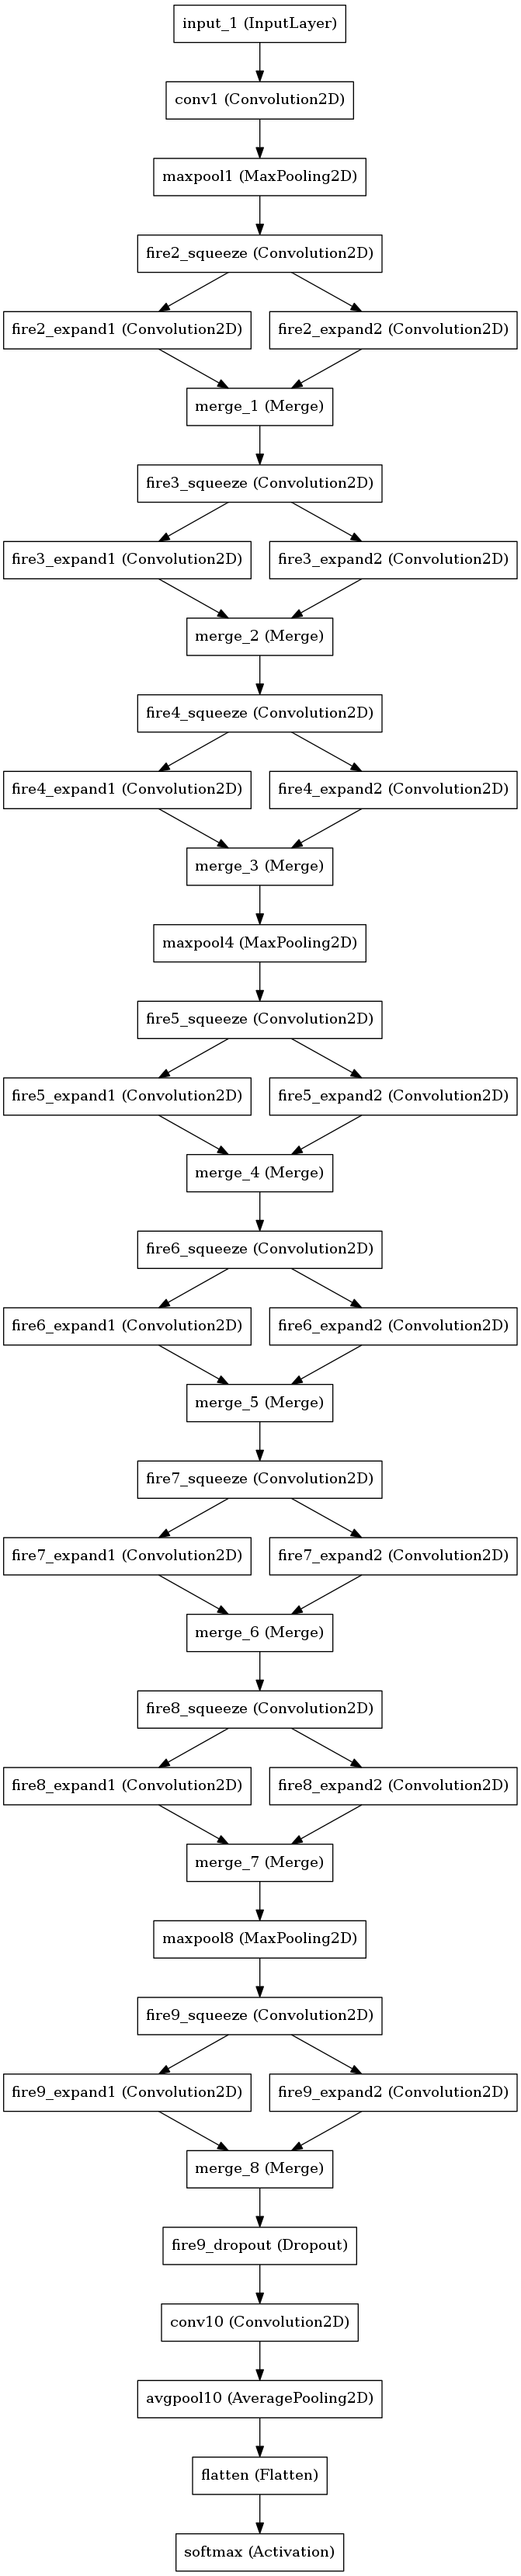

In [74]:
!pip install tensorflow

In [9]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Activation, Concatenate
from keras.layers import Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D,GlobalAvgPool2D

In [59]:
img_width, img_height = 227, 227
batch_size = 8
epochs = 100

In [23]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=40)

validation_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=40)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = validation_datagen.flow_from_directory(
validation_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 15863 images belonging to 4 classes.
Found 6101 images belonging to 4 classes.


1. Implementation_1

In [66]:
def SqueezeNet(nb_classes, inputs=(227,227,3)):
    """ Keras Implementation of SqueezeNet(arXiv 1602.07360)
    @param nb_classes: total number of final categories
    Arguments:
    inputs -- shape of the input images (channel, cols, rows)
    """

    input_img = Input(shape=inputs)
    conv1 = Conv2D(
        96, (7, 7), activation='relu', kernel_initializer='glorot_uniform',
        strides=(2, 2), padding='same', name='conv1')(input_img)
    maxpool1 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool1')(conv1)
    fire2_squeeze = Conv2D(
        16, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_squeeze')(maxpool1)
    fire2_expand1 = Conv2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_expand1')(fire2_squeeze)
    fire2_expand2 = Conv2D(
        64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_expand2')(fire2_squeeze)
    merge2 = Concatenate(axis=1)([fire2_expand1, fire2_expand2])

    fire3_squeeze = Conv2D(
        16, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_squeeze')(merge2)
    fire3_expand1 = Conv2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_expand1')(fire3_squeeze)
    fire3_expand2 = Conv2D(
        64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_expand2')(fire3_squeeze)
    merge3 = Concatenate(axis=1)([fire3_expand1, fire3_expand2])

    fire4_squeeze = Conv2D(
        32, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_squeeze')(merge3)
    fire4_expand1 = Conv2D(
        128, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_expand1')(fire4_squeeze)
    fire4_expand2 = Conv2D(
        128, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_expand2')(fire4_squeeze)
    merge4 = Concatenate(axis=1)([fire4_expand1, fire4_expand2])
    maxpool4 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool4')(merge4)

    fire5_squeeze = Conv2D(
        32, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_squeeze')(maxpool4)
    fire5_expand1 = Conv2D(
        128, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_expand1')(fire5_squeeze)
    fire5_expand2 = Conv2D(
        128, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_expand2')(fire5_squeeze)
    merge5 = Concatenate(axis=1)([fire5_expand1, fire5_expand2])

    fire6_squeeze = Conv2D(
        48, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_squeeze')(merge5)
    fire6_expand1 = Conv2D(
        192, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_expand1')(fire6_squeeze)
    fire6_expand2 = Conv2D(
        192, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_expand2')(fire6_squeeze)
    merge6 = Concatenate(axis=1)([fire6_expand1, fire6_expand2])

    fire7_squeeze = Conv2D(
        48, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_squeeze')(merge6)
    fire7_expand1 = Conv2D(
        192, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_expand1')(fire7_squeeze)
    fire7_expand2 = Conv2D(
        192, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_expand2')(fire7_squeeze)
    merge7 = Concatenate(axis=1)([fire7_expand1, fire7_expand2])

    fire8_squeeze = Conv2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_squeeze')(merge7)
    fire8_expand1 = Conv2D(
        256, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_expand1')(fire8_squeeze)
    fire8_expand2 = Conv2D(
        256, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_expand2')(fire8_squeeze)
    merge8 = Concatenate(axis=1)([fire8_expand1, fire8_expand2])

    maxpool8 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool8')(merge8)
    """
    fire9_squeeze = Conv2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_squeeze')(maxpool8)
    fire9_expand1 = Conv2D(
        256, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_expand1')(fire9_squeeze)
    fire9_expand2 = Conv2D(
        256, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_expand2')(fire9_squeeze)
        """
    merge9 = Concatenate(axis=1)([fire8_expand1, fire8_expand2])
    fire9_dropout = Dropout(0.5, name='fire9_dropout')(merge9)
    conv10 = Conv2D(
        nb_classes, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='valid', name='conv10')(fire9_dropout)

    global_avgpool10 = GlobalAveragePooling2D()(conv10)
    softmax = Activation("softmax", name='softmax')(global_avgpool10)

    return Model(inputs=input_img, outputs=softmax)

2. Implementation_2

In [37]:
def squeezenet(input_shape, n_classes):

  def fire(x, fs, fe):
    s = Conv2D(fs, 1, activation='relu')(x)
    e1 = Conv2D(fe, 1, activation='relu')(s)
    e3 = Conv2D(fe, 3, padding='same', activation='relu')(s)
    output = Concatenate()([e1, e3])
    return output


  input = Input(input_shape)

  x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = fire(x, 16, 64)
  x = fire(x, 16, 64)
  x = fire(x, 32, 128)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = fire(x, 32, 128)
  x = fire(x, 48, 192)
  x = fire(x, 48, 192)
  x = fire(x, 64, 256)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = fire(x, 64, 256)
  x = Conv2D(n_classes, 1)(x)
  x = GlobalAvgPool2D()(x)

  output = Activation('softmax')(x)

  model = Model(input, output)
  return model

In [69]:
model_squeezeNet=SqueezeNet(nb_classes = 4,inputs = (227,227,3))

In [70]:
model_squeezeNet.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [55]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [56]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') is not None and logs.get('acc') > 0.959:
            print("\nReached 99.9% accuracy, so cancelling training!")
            self.model.stop_training = True

In [57]:
file_name = 'my_saved_model_SqueezeNet'
tensorboard =TensorBoard(log_dir="/content/drive/MyDrive/Stage/Stage Falcon/logs/{}".format(file_name))

callbacks = myCallback()
# Callbacks
cb = [
    ModelCheckpoint("SqueezeNet_model.h5", save_best_only=True),
    tensorboard,
    callbacks
    ]

In [71]:
from tensorflow.keras import mixed_precision

In [72]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [73]:
history = model_SqueezeNet.fit(
train_generator,
steps_per_epoch = batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = batch_size,
callbacks=cb)

Epoch 1/100
8/8 [==============================] - 273s 11s/step - loss: 1.3867 - accuracy: 0.3320 - val_loss: 1.3867 - val_accuracy: 0.3516
Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 1.3867 - accuracy: 0.3242 - val_loss: 1.3867 - val_accuracy: 0.2617
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 1.3867 - accuracy: 0.2500 - val_loss: 1.3867 - val_accuracy: 0.2930
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 1.3867 - accuracy: 0.3516 - val_loss: 1.3867 - val_accuracy: 0.3477
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 1.3867 - accuracy: 0.3633 - val_loss: 1.3867 - val_accuracy: 0.3320
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 1.3867 - accuracy: 0.3359 - val_loss: 1.3867 - val_accuracy: 0.3125
Epoch 7/100
8/8 [==============================] - 9s 1s/step - loss: 1.3867 - accuracy: 0.3125 - val_loss: 1.3867 - val_accuracy: 0.3320
Epoch 8/100
8/8 [=============

**Transfer Learning with Inception V3**

In [ ]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

**Transfer Learning with MobileNet**

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# parameters for architecture
input_shape = (224, 224, 3)
num_classes = 2
conv_size = 32

# parameters for training
batch_size = 16
num_epochs = 20

# load MobileNet from Keras
MobileNet_model = MobileNet(include_top=False, input_shape=input_shape)

# add custom Layers
x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
Custom_Output = Dense(num_classes, activation='softmax')(x)

# define the input and output of the model
MobileNet_model = Model(inputs = MobileNet_model.input, outputs = Custom_Output)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
# compile the model
MobileNet_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

MobileNet_model.summary()